In [82]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

$$
\widehat{J}_{N}(\varepsilon)=\left\{\begin{array}{cll}
\inf _{x, \tau, \lambda, s_{i}, \gamma_{i k}} & \lambda \varepsilon+\frac{1}{N} \sum_{i=1}^{N} s_{i} \\
& \text { s.t. } & x \in \mathbb{X} \\
& b_{k} \tau+a_{k}\left\langle x, \widehat{\xi}_{i}\right\rangle+\left\langle\gamma_{i k}, d-C \widehat{\xi}_{i}\right\rangle \leq s_{i} & \forall i \leq N, \forall k \leq K \\
& \left\|C^{\top} \gamma_{i k}-a_{k} x\right\|_{*} \leq \lambda & \forall i \leq N, \forall k \leq K \\
& \gamma_{i k} \geq 0 & \forall i \leq N, \forall k \leq K .
\end{array}\right.
$$

In [83]:
m = 10
N = 30
Nd = 1
K = 2
rho = 10
alpha = 0.2

x = cp.Variable((m,1),nonneg=True)
tau = cp.Variable()
lambda_ = cp.Variable()
s = cp.Variable((N,1))
gamma_ik = [ [cp.Variable((Nd,1)) for i in range(N)] for j in range(K)]

eps = cp.Parameter(nonneg=True)
eps.value = 0.1
a1 = -1
a2 = -1 - rho/alpha
b1 = rho
b2 = rho * (1 - 1/alpha)
a = [a1, a2]
b = [b1, b2]

C = np.zeros((Nd,m))
d = np.zeros((Nd,1))

xi_hat_para = cp.Parameter((m,N))

In [84]:
obj = cp.Minimize(lambda_ * eps + 1/N * cp.sum(s))
constraint = [cp.sum(x) == 1]

for k in range(K):
  for i in range(N):
    constraint += [b[k]*tau + a[k] * x.T @ xi_hat_para[:,i] + gamma_ik[k][i].T @ (d - C @ xi_hat_para[:,i]) <= s[i]]
    constraint += [ cp.norm(C.T @ gamma_ik[k][i] - a[k] * x , "inf") <= lambda_]
    constraint += [ gamma_ik[k][i] >= 0]

In [85]:
np.random.seed(1)
xi_hat_list = []
for i in range(N):
    psi = np.sqrt(0.02) * np.random.randn(1)
    xi_temp_list = []
    for j in range(m):
        zeta_i = np.sqrt( (j+1) * 0.025) * np.random.randn(1) + (j+1) * 0.03
        xi = psi + zeta_i
        xi_temp_list += [xi]
    xi_hat_list += [np.array(xi_temp_list).reshape(-1,1)]
    # xi_hat_list = np.hstack((xi_hat_list, np.array(xi_temp_list).reshape(-1,1)))

In [64]:
xi_hat_para.shape

(10, 30)

In [65]:
xi_hat_sample = np.concatenate( xi_hat_list, axis=1)
# xi_hat_sample = np.concatenate( xi_hat_list, axis=1).shape
xi_hat_para.value = xi_hat_sample


$$
\psi \sim \mathcal{N}(0,2 \%)
$$

$$
\zeta_{i} \sim \mathcal{N}(i \times 3 \%, i \times 2.5 \%)
$$

$$
\xi_{i}=\psi+\zeta_{i}
$$

$$
\|z\|_{*}:=\sup _{\|\xi\| \leq 1}\langle z, \xi\rangle
$$

In [66]:
prob = cp.Problem(obj, constraint)
prob.solve()

0.06568634943565405

In [67]:
x.value

array([[1.24221166e-13],
       [1.34378524e-01],
       [1.34378524e-01],
       [8.27777843e-02],
       [1.10951070e-01],
       [1.34378524e-01],
       [0.00000000e+00],
       [1.34378524e-01],
       [1.34378524e-01],
       [1.34378524e-01]])

In [69]:
np.zeros((m,1))

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [71]:
N_sim = 30
x_ave_list = []

eps_scale = np.logspace(-3, 0, 10, endpoint=True)
for eps_temp in eps_scale:
    eps.value = eps_temp
    x_sum = np.zeros((m,1))
    print(eps_temp)
    for _ in range(N_sim):
        xi_hat_list = []
        for i in range(N):
            psi = np.sqrt(0.02) * np.random.randn(1)
            xi_temp_list = []
            for j in range(m):
                zeta_i = np.sqrt((j+1) * 0.025) * np.random.randn(1) + (j+1) * 0.03
                xi = psi + zeta_i
                xi_temp_list += [xi]
            xi_hat_list += [np.array(xi_temp_list).reshape(-1,1)]

        xi_hat_sample = np.concatenate( xi_hat_list, axis=1)
        xi_hat_para.value = xi_hat_sample
        
        prob = cp.Problem(obj, constraint)
        prob.solve()

        x_sum += x.value
    x_ave_list += [x_sum/N_sim]

0.001
0.0021544346900318843
0.004641588833612777
0.01
0.021544346900318832
0.046415888336127774
0.1
0.21544346900318823
0.46415888336127775
1.0


In [75]:
x_ave_list
x_ave_np = np.concatenate(x_ave_list, axis=1)
x_ave_np

array([[0.00657414, 0.02121984, 0.01796812, 0.007104  , 0.01430076,
        0.04994495, 0.04741586, 0.09388337, 0.10058643, 0.1       ],
       [0.04423712, 0.01718036, 0.03475433, 0.04978397, 0.03241714,
        0.02936895, 0.08351015, 0.09327131, 0.09791076, 0.1       ],
       [0.08786582, 0.07363428, 0.0532827 , 0.04556614, 0.08376229,
        0.07615346, 0.07703635, 0.09782458, 0.10121454, 0.1       ],
       [0.08634782, 0.09846839, 0.08298219, 0.08839804, 0.09963412,
        0.07154556, 0.1038966 , 0.11453917, 0.10155345, 0.1       ],
       [0.10175535, 0.09060246, 0.09041335, 0.10865947, 0.11097839,
        0.07171183, 0.08031742, 0.09378288, 0.09689472, 0.1       ],
       [0.10312428, 0.11033385, 0.10911632, 0.13230257, 0.11112254,
        0.10717635, 0.09886194, 0.09282987, 0.09718471, 0.1       ],
       [0.10318555, 0.10377536, 0.11545511, 0.12070907, 0.14161489,
        0.14934597, 0.12432923, 0.10150543, 0.10160471, 0.1       ],
       [0.1573507 , 0.1244221 , 0.2110406

In [76]:
xi_ave_sum_np = x_ave_np
for i in range(1,m):
    xi_ave_sum_np[i,:] = xi_ave_sum_np[i-1,:] + xi_ave_sum_np[i,:]

In [80]:
xi_print_list = []
for i in range(m):
    xi_print_list += [xi_ave_sum_np[i,:].flatten().tolist()]
xi_print_list

[[0.006574141459885774,
  0.021219840231286854,
  0.017968121288963225,
  0.007104000190706467,
  0.01430075937366266,
  0.049944950582355374,
  0.04741585728699208,
  0.0938833659261553,
  0.10058643334295521,
  0.1000000000000203],
 [0.050811258647512826,
  0.03840019623406832,
  0.05272245005888477,
  0.05688796889013194,
  0.046717901756195626,
  0.0793138976413657,
  0.1309260067936292,
  0.18715467841669453,
  0.19849719693764978,
  0.19999999999943815],
 [0.13867707848239338,
  0.11203447526840529,
  0.10600514695711241,
  0.1024541079808454,
  0.13048018902856845,
  0.15546736061266794,
  0.2079623542283795,
  0.28497925457961026,
  0.2997117341346554,
  0.29999999999986926],
 [0.22502489503729073,
  0.21050286720940975,
  0.18898733410214436,
  0.19085215162899416,
  0.23011431173505248,
  0.22701292307571658,
  0.3118589552920646,
  0.3995184244287067,
  0.40126518056802,
  0.39999999999917535],
 [0.32678024743153017,
  0.30110533178652066,
  0.2794006867113743,
  0.299511623

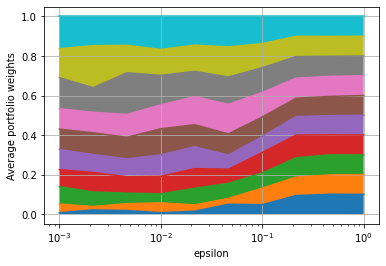

In [86]:
plt.figure(1)
plt.clf()

legend = []
for i in range (m):
    plt.xscale('log')
    plt.plot(eps_scale, xi_print_list[i])
    if i == 0:
        plt.fill_between(eps_scale, xi_print_list[i],0)
    
    if i > 0:
        plt.fill_between(eps_scale, xi_print_list[i-1], xi_print_list[i])
#     legend += ['x'+ str(i)]

plt.xlabel('epsilon')
plt.ylabel('Average portfolio weights')

plt.grid()
plt.show()


$$
J\left(\widehat{x}_{N}(\varepsilon)\right):=\mathbb{E}^{\mathbb{P}}\left[-\left\langle\widehat{x}_{N}(\varepsilon), \xi\right\rangle\right]+\rho \mathbb{P}-\operatorname{CVaR}_{\alpha}\left(-\left\langle\widehat{x}_{N}(\varepsilon), \xi\right\rangle\right)
$$